In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Some default functions
def mean_absolute_percentage_error(true, pred):
    return np.mean(np.abs((true - pred) / true)) * 100

In [3]:
data = pd.read_csv('stock_prices_sample.csv', index_col=['DATE'], parse_dates=['DATE'])
data.head()

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


In [4]:
data.shape

(999, 17)

In [5]:
data['TICKER'].value_counts()

GF     996
GEF      3
Name: TICKER, dtype: int64

In [6]:
data['TYPE'].value_counts()

EOD         998
Intraday      1
Name: TYPE, dtype: int64

In [7]:
df = data[data.TICKER != 'GEF']
df = df[df.TYPE != 'Intraday']

In [8]:
drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 
             'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']
df.drop(drop_cols, axis=1, inplace=True)
df.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


## EDA

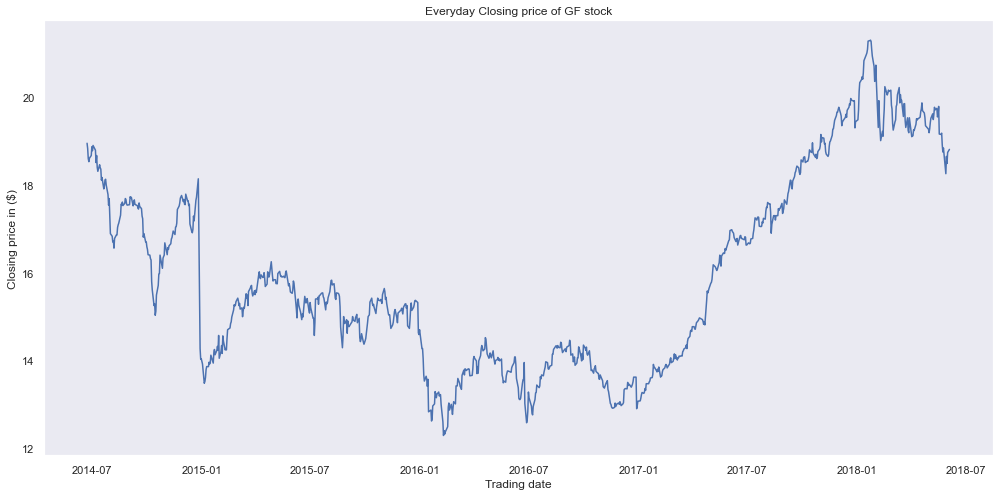

In [9]:
plt.figure(figsize=(17, 8))
plt.plot(df.CLOSE)
plt.title('Everyday Closing price of GF stock')
plt.ylabel('Closing price in ($)')
plt.xlabel('Trading date')
plt.grid(False)
plt.show()

## Analyzing the series for Trends

## A function for Moving Average

In [10]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average-window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

In [11]:
df.CLOSE

DATE
2018-06-04    18.8100
2018-06-01    18.7400
2018-05-31    18.4900
2018-05-30    18.6500
2018-05-29    18.2562
               ...   
2014-06-27    18.6100
2014-06-26    18.5300
2014-06-25    18.6000
2014-06-24    18.8300
2014-06-23    18.9500
Name: CLOSE, Length: 995, dtype: float64

In [12]:
df.CLOSE[2:]

DATE
2018-05-31    18.4900
2018-05-30    18.6500
2018-05-29    18.2562
2018-05-25    18.8420
2018-05-24    18.7500
               ...   
2014-06-27    18.6100
2014-06-26    18.5300
2014-06-25    18.6000
2014-06-24    18.8300
2014-06-23    18.9500
Name: CLOSE, Length: 993, dtype: float64

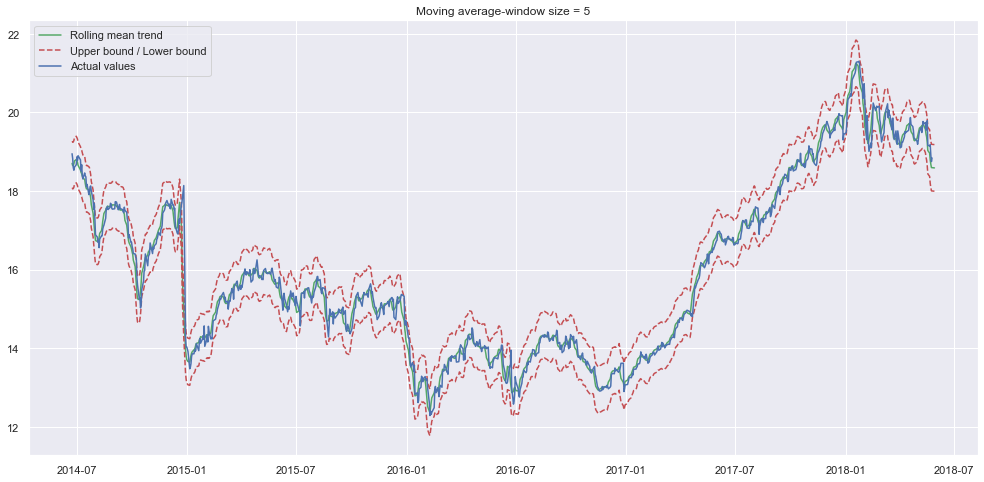

In [13]:
#Smooth by previous 5 days (5 days)
plot_moving_average(df.CLOSE, 5, plot_intervals=True)

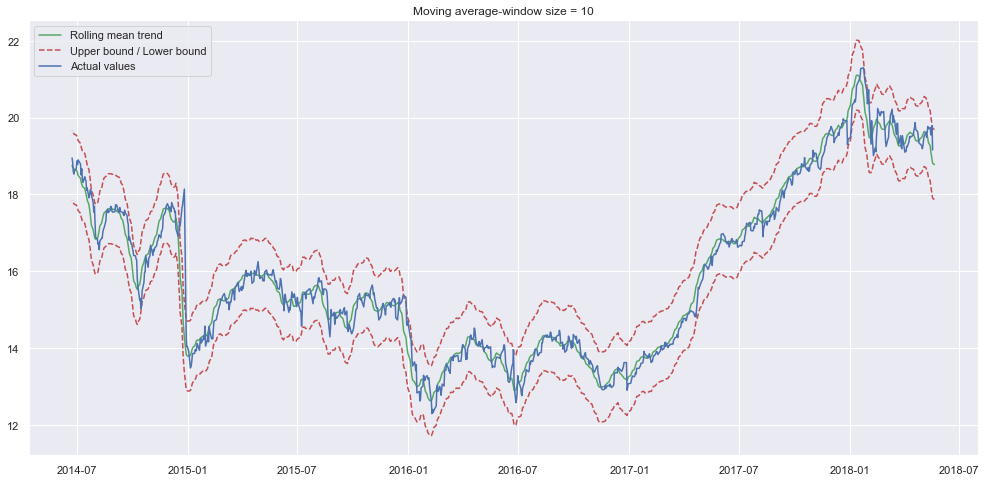

In [14]:
#Smooth by previous 10 days (10 days)
plot_moving_average(df.CLOSE, 10, plot_intervals=True)

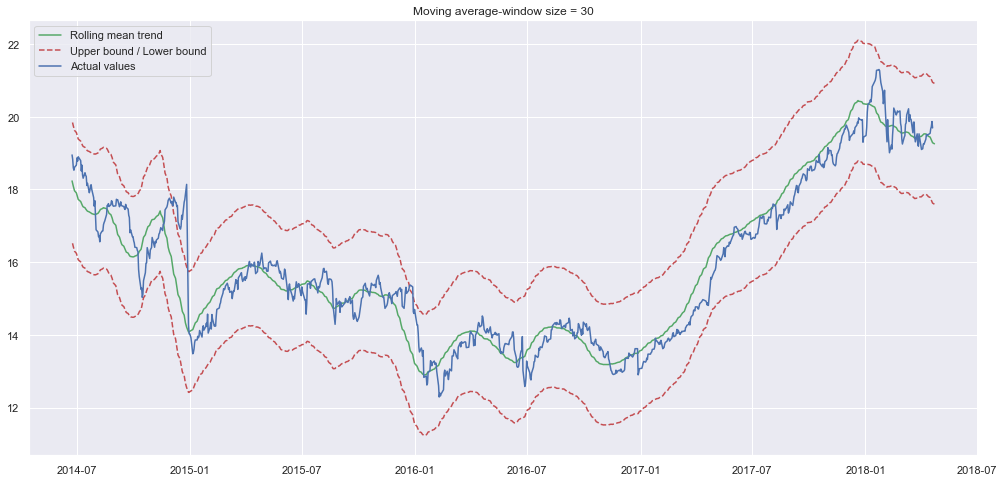

In [15]:
#Smooth by previous 30 days (30 days)
plot_moving_average(df.CLOSE, 30, plot_intervals=True)

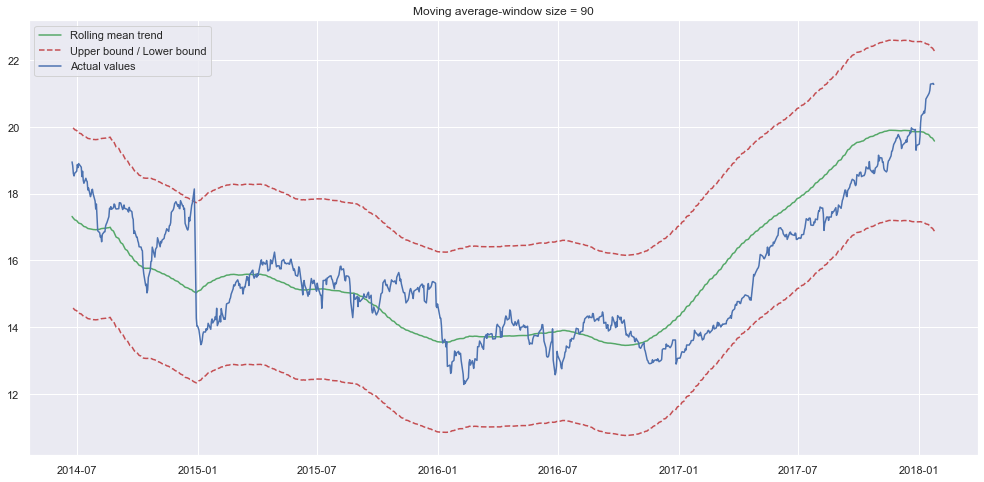

In [16]:
#Smooth by previous 90 days (90 days)
plot_moving_average(df.CLOSE, 90, plot_intervals=True)

Can spot some trend at a lag of 90 days

## Exponential Smoothing

In [17]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [18]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

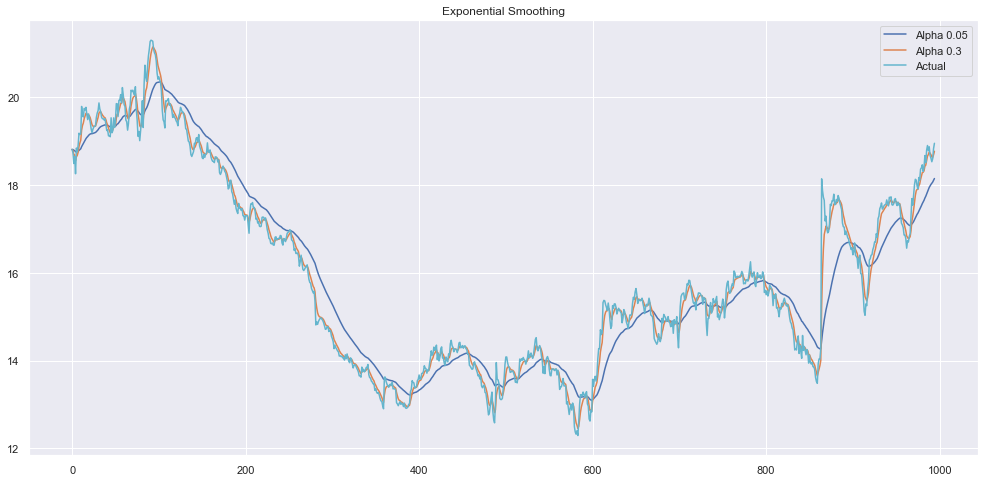

In [19]:
#after trying combination of values, 0.05 and 0.3 worked best for the data
plot_exponential_smoothing(df.CLOSE, [0.05, 0.3])

## Double Exponential smoothing

In [20]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [21]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

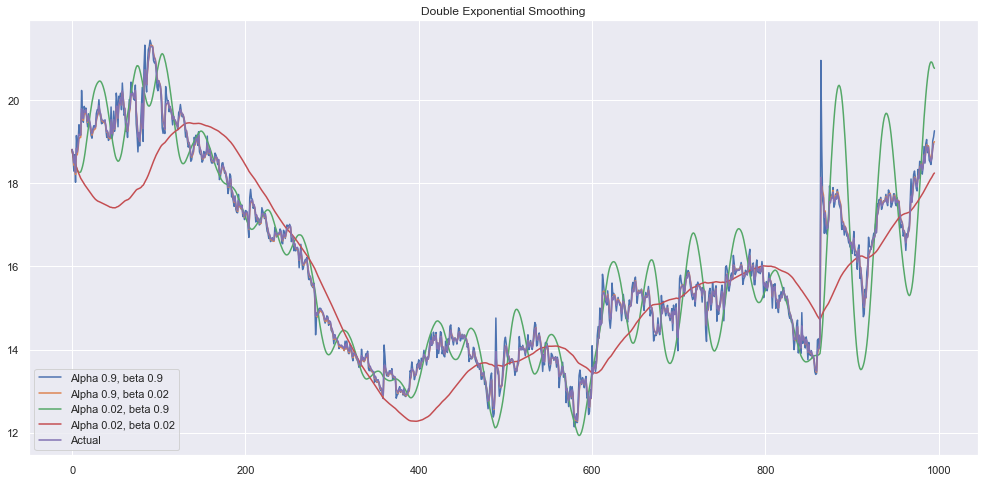

In [22]:
plot_double_exponential_smoothing(df.CLOSE, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Stationarity

In [23]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

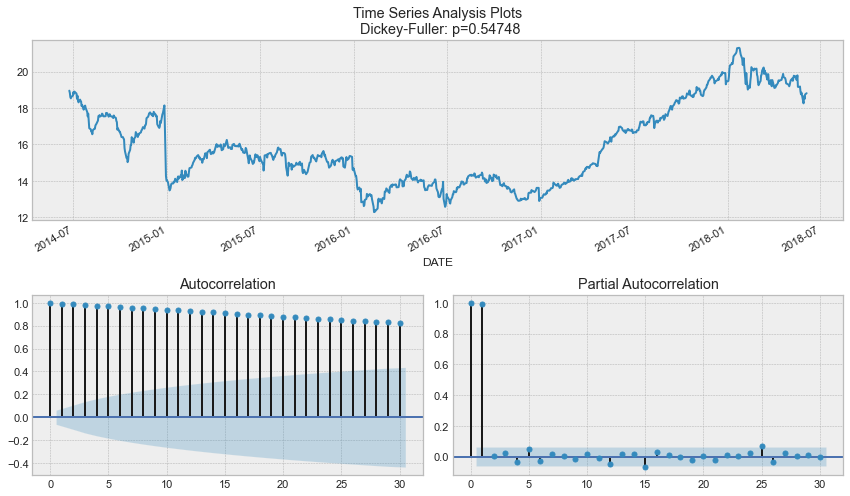

In [24]:
tsplot(df.CLOSE, lags=30)

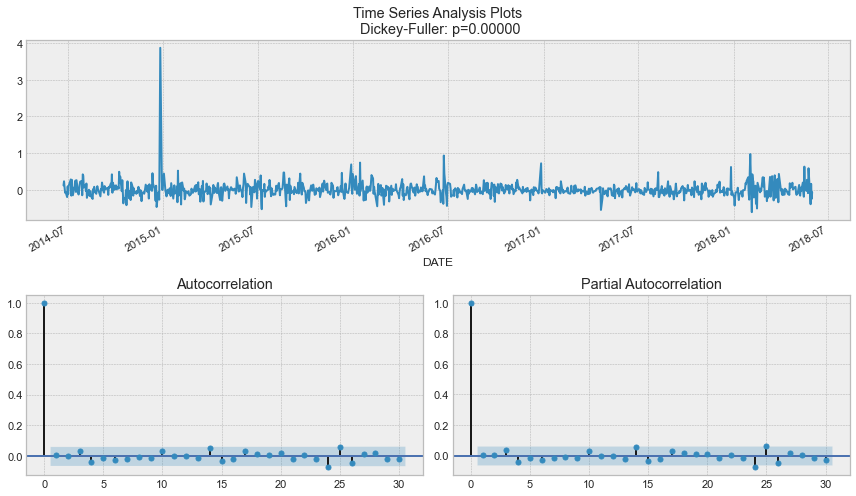

In [25]:
df_diff = df.CLOSE - df.CLOSE.shift(1)
tsplot(df_diff[1:], lags=30)

# Modeling

## SARIMA

In [26]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [27]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df.CLOSE, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [28]:
result_table = optimize_SARIMA(parameters_list, d, D, s)

In [29]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df.CLOSE, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                          SARIMAX Results                                           
Dep. Variable:                                        CLOSE   No. Observations:                  995
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2, 3, 4], 5)   Log Likelihood                 148.875
Date:                                      Sat, 27 Mar 2021   AIC                           -283.751
Time:                                              04:27:41   BIC                           -249.474
Sample:                                                   0   HQIC                          -270.716
                                                      - 995                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.4937      0.162  

In [30]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'CLOSE': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);

In [31]:
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=df.CLOSE.shape[0], end=df.CLOSE.shape[0] + 5))
print(mean_absolute_percentage_error(df.CLOSE[s+d:], best_model.fittedvalues[s+d:]))

995     18.958793
996     18.966213
997     18.961051
998     18.923004
999     18.944804
1000    18.922448
dtype: float64
0.7854714567437282


In [33]:
res_data = pd.DataFrame({'actual': [18.93, 19.23, 19.08, 19.17, 19.11, 19.12],
                          'predicted': [18.96, 18.97, 18.96, 18.92, 18.94, 18.92]}, 
                          index = pd.date_range(start='2018-06-05', periods=6,))

In [34]:
res_data.head()

,actual,predicted
2018-06-05,18.93,18.96
2018-06-06,19.23,18.97
2018-06-07,19.08,18.96
2018-06-08,19.17,18.92
2018-06-09,19.11,18.94


No handles with labels found to put in legend.


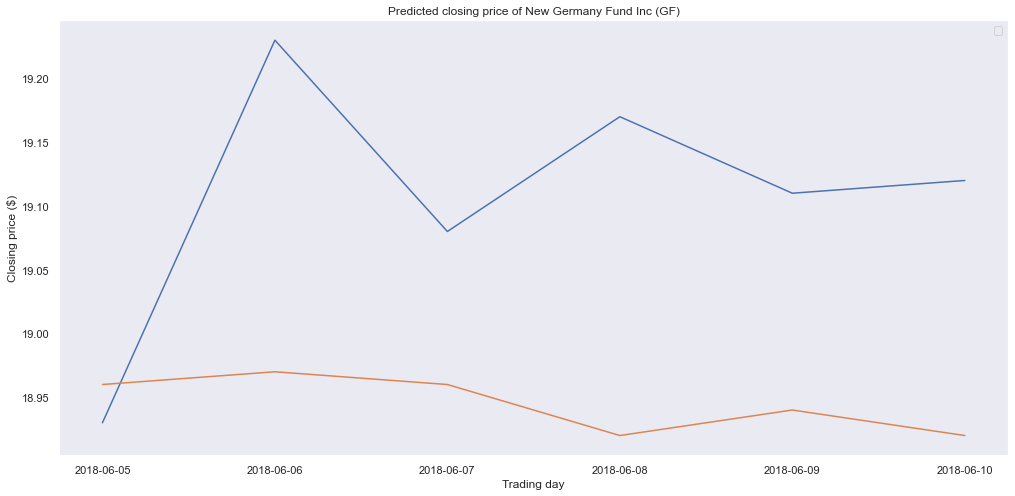

In [35]:
plt.figure(figsize=(17, 8))
plt.plot(res_data.actual)
plt.plot(res_data.predicted)
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()